In [1]:
import spacy


from pathlib import Path


from spacy.tokens import Doc
from spacy.vocab import Vocab


import numpy as np

from collections import Counter

from tqdm import tqdm

In [2]:

root = Path('../data/sections')

# Data

In [3]:
def loader():
    for path in tqdm(sorted(root.glob('*.spacy'))):
        doc = Doc(Vocab()).from_disk(path)
        yield doc

# TF-IDF 

In [4]:
import re

In [5]:
fix_whitespace = re.compile('\s+')

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
tfidf = TfidfVectorizer(sublinear_tf=True)

context_size = 10
corpus = []
i2ent = []
ent2i = {}
i = 0
for doc in loader():
    for ent in doc.ents:
        before = doc[ent.start-context_size:ent.start]

        after = doc[ent.end:ent.end+context_size]
        ent2i.setdefault(ent.text, [])
        ent2i[ent.text].append(i)
        i2ent.append(ent.text)
        corpus.append(before.text + ' ' + after.text)
        i+=1
        # after_text = fix_whitespace.sub(' ', after.text)
        # before_text = fix_whitespace.sub(' ', before.text)
        # print(before_text,'**', fix_whitespace.sub(' ',ent.text),'**', after_text)

In [87]:
context_size = 10
corpus = []
ent_contexts = {}
i = 0
for doc in loader():
    for ent in doc.ents:
#         before = doc[ent.start-context_size:ent.start]

#         after = doc[ent.end:ent.end+context_size]
#         context = before.text + ' ' + after.text
        context = doc[ent.start-context_size:ent.end+context_size].text
        ent_contexts.setdefault(ent.text, [])
        ent_contexts[ent.text].append(context)
    #break

100%|██████████| 107/107 [00:07<00:00, 14.96it/s]


In [88]:
ents_texts, corpus = [], []
for ent_text, ent_context in ent_contexts.items():
    ents_texts.append(ent_text)
    corpus.append(' '.join(ent_context))

In [89]:
len(ent_contexts), len(ents_texts), len(corpus)

(8523, 8523, 8523)

In [90]:
ents_texts[1], len(ent_contexts[ents_texts[1]]), corpus[1]

('Swann',
 1030,
 " \xa0:\n«\xa0Je reconnais la voix de Swann.\xa0» On ne le reconnaissait en effet qu’ était accouru auprès de lui dans la propriété que les Swann\npossédaient aux environs de Combray, et avait réussi \npeu à la fois, comme le pauvre père Swann\xa0», était devenu une des phrases\nfavorites différentes. Il m’aurait paru que ce père de Swann était un monstre, si mon\ngrand-père que je incognito\nque lui faisait chez nous ce nom de Swann, ils hébergeaient –\xa0avec la\nparfaite innocence nous étions de cette brillante vie mondaine\nque menait Swann tenait évidemment en partie à la réserve et à la l’on\navait voulu à toute force appliquer à Swann un coefficient social qui lui fût\npersonnel, entre cause du rôle ridicule que s’y\ndonnait toujours Swann ou de l’esprit qu’il mettait à les conter \nfaire remarquer aux étrangers, quand on parlait de Swann, qu’il aurait pu, s’il\navait dire\xa0: «\xa0Eh bien\xa0! Monsieur Swann, vous habitez\ntoujours près de l’Entrepôt des si l

In [91]:
doc_term = tfidf.fit_transform(corpus)

In [92]:
ent_terms = doc_term

In [93]:
doc_term.shape

(8523, 24427)

In [94]:
terms = np.array(list(tfidf.vocabulary_.keys()))
indices = np.array(list(tfidf.vocabulary_.values()))
inverse_vocabulary = terms[np.argsort(indices)]

ent_term = {}

ent_texts, ent_terms = [], []
for ent_text, ent_i in ent2i.items():
    ent_terms.append(doc_term[np.array(ent_i)].mean(axis=0).A1)
    ent_texts.append(ent_text)

In [95]:
contexts = []
for ent_term in ent_terms:
    context = inverse_vocabulary[np.argsort(ent_term.A[0])[-5:]]
    contexts.append(', '.join(context))

In [96]:
contexts[1]

'jalousie, forcheville, phrase, odette, swann'

# Word2Vec 

In [35]:
ents_counter = Counter()
ents_vectors = dict()

for path in tqdm(sorted(root.glob('*.spacy'))):
    doc = Doc(Vocab()).from_disk(path)
    for ent in doc.ents:
        ents_counter[ent.text]+=1
        if ent.text not in ents_vectors:
            ents_vectors[ent.text] = ent.vector

100%|██████████| 108/108 [00:16<00:00,  6.55it/s]


In [36]:
ents_counter.most_common(100)

[('Albertine', 1890),
 ('Swann', 1030),
 ('M.\xa0de\xa0Charlus', 831),
 ('Balbec', 661),
 ('Françoise', 644),
 ('Saint-Loup', 639),
 ('Gilberte', 570),
 ('Odette', 547),
 ('Guermantes', 521),
 ('Paris', 501),
 ('Morel', 417),
 ('Mme\xa0Verdurin', 401),
 ('Bloch', 385),
 ('Mme\xa0de\xa0Guermantes', 367),
 ('Combray', 361),
 ('Robert', 301),
 ('Mme\xa0de\xa0Villeparisis', 297),
 ('Andrée', 296),
 ('Bergotte', 283),
 ('Mme\xa0Swann', 271),
 ('Brichot', 269),
 ('Verdurin', 268),
 ('Elstir', 233),
 ('Cottard', 208),
 ('Ah\xa0!', 206),
 ('Jupien', 196),
 ('Mme\xa0', 188),
 ('M.\xa0de\xa0Norpois', 173),
 ('Oriane', 146),
 ('Rachel', 135),
 ('Venise', 133),
 ('M.\xa0Verdurin', 127),
 ('M.\xa0de\xa0Guermantes', 120),
 ('Legrandin', 117),
 ('Berma', 114),
 ('duchesse de Guermantes', 110),
 ('Vinteuil', 109),
 ('Monsieur', 103),
 ('Mlle\xa0Vinteuil', 103),
 ('Charlus', 100),
 ('Mme\xa0de\xa0Cambremer', 96),
 ('Aimé', 94),
 ('princesse de Parme', 93),
 ('Cambremer', 93),
 ('Forcheville', 92),
 ('D

In [37]:
len(ents_vectors)

8528

In [38]:
list(ents_counter) == list(ents_vectors)

True

In [39]:
list(ents_counter)[:100],list(ents_vectors)[:100]

(['RECHERCHE DU TEMPS',
  'Marcel Proust',
  'Web',
  'Marcel Proust\nmarcel-proust.com\n\xa0\n\n',
  'général A',
  'Versailles',
  'Texte',
  'Côté de Chez',
  'Swann',
  'Swann\nPremière',
  'Combray\nI.\nLongtemps',
  'François\xa0',
  'Charles Quint',
  '–\xa0date pour moi d’une ère nouvelle\xa0',
  'Ève',
  'Adam',
  'Si',
  '–\xa0mon corps',
  'Bohême',
  'Sienne',
  'Combray',
  'grands-parents',
  'Mme\xa0de\xa0Saint-Loup',
  'Dieu\xa0!',
  'Tansonville',
  'Débats roses',
  'hirondelle\nde mer',
  'lune',
  'Louis\xa0XVI',
  'le bon ange',
  'Balbec',
  'Paris',
  'Doncières',
  'Venise',
  'Golo',
  'Geneviève de Brabant',
  'Geneviève',
  'Brabant',
  'porte de ma\nchambre',
  'Barbe-Bleue',
  'Françoise',
  '–\xa0à\nun des moments où la révolution',
  'cognac\xa0!',
  'Roussainville-le-Pin',
  'volupté',
  'M.\xa0Swann',
  'grand\nmarronnier',
  'M.\xa0Swann\xa0',
  'Bressant',
  'homme\nexcellent',
  'chambre\nmortuaire',
  'soleil',
  'Ah\xa0!',
  'Amédée\xa0!',
  'incog

In [45]:
embeddings = np.stack(list(ents_vectors.values()))

In [46]:
embeddings.shape

(8528, 96)

# UMAP

In [41]:
import umap

/home/lerner/anaconda3/envs/meerqat/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [97]:
model = umap.UMAP(metric='cosine')

In [98]:
embeddings = ent_terms

In [99]:
model.fit(embeddings)

UMAP(angular_rp_forest=True, metric='cosine', tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [100]:
reduced_embeddings = model.transform(embeddings)

In [101]:
reduced_embeddings.shape

(8523, 2)

In [102]:
import matplotlib.pyplot as plt

In [103]:
#sizes = np.array(list(ents_counter.values()))
sizes = np.array([len(ent_contexts[ent_text]) for ent_text in ents_texts])

In [104]:
quotes = [ent_contexts[ent_text][0] for ent_text in ents_texts]

In [105]:
len(quotes)

8523

In [107]:
quotes[5]

'quatuor, la rivalité de François\xa0Ier et de Charles Quint. Cette\ncroyance survivait pendant quelques secondes à mon'

In [108]:
sizes.shape

(8523,)

In [109]:
pd.DataFrame(sizes).describe()

,0
count,8523.000000
mean,3.841488
std,33.576757
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1890.000000


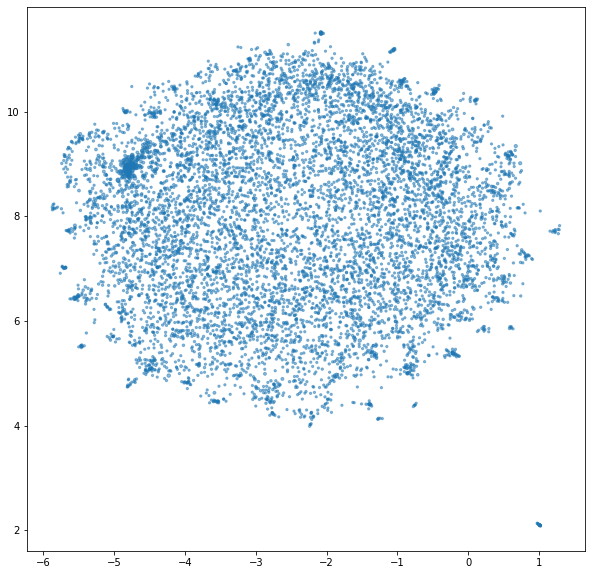

In [110]:
plt.figure(figsize=(10,10))
plt.scatter(reduced_embeddings[:,0],reduced_embeddings[:,1],s=np.sqrt(sizes)+4,alpha=0.5)

In [111]:
import pandas as pd

In [112]:
df = pd.DataFrame(dict(text = ents_texts, x = reduced_embeddings[:,0], y=reduced_embeddings[:,1], size=np.sqrt(sizes)+4,context=contexts,quote=quotes))

In [113]:
df

,text,x,y,size,context,quote
0,Côté de Chez,-3.058391,6.590609,5.414214,"combray, longtemps, chez, swann, côté",
1,Swann,-4.827812,8.919872,36.093613,"jalousie, forcheville, phrase, odette, swann",
2,Swann\nPremière,-3.162818,6.615802,5.000000,"première, combray, longtemps, chez, swann",de Chez Swann\n1. Du Côté de Chez Swann\nPremi...
3,Combray\nI.\nLongtemps,-3.291183,6.701195,5.000000,"combray, longtemps, bonne, parfois, couché",. Du Côté de Chez Swann\nPremière partie : Com...
4,François,-0.302505,7.314362,5.000000,"ier, quatuor, survivait, rivalité, quint","une église,\nun quatuor, la rivalité de Franço..."
...,...,...,...,...,...,...
8518,Les Mille et Une Nuits\npeut-être,1.015671,2.092230,5.000000,"ennuyeuse, ennuyer, ennuyassent, ennuyée, σεαυτóν",
8519,« Suis-je,-1.388952,8.227105,5.000000,"temps, suis, état, encore, maladie",Est-il encore temps ? »\nmais « Suis-je encor...
8520,François le Champi !,-1.800248,5.295075,5.000000,"françois, apercevant, champi, évoquée, soirée",la soirée que j'avais alors évoquée\nen aperce...
8521,sonnette\n,-3.370722,8.292276,5.000000,"frais, sonnette, intarissable, ferrugineux, cr...","ferrugineux, intarissable, criard et frais de ..."


In [120]:
writers = df[(df.x < -5) & (df.y > 8)]

In [123]:
writers.to_csv('../data/writers.csv')

In [124]:
df.to_csv('../data/tfidif2_ents_umap_with_ctx_and_quote3.csv')

In [129]:
!cd ..
!pwd

/home/lerner/Documents/proust/code


In [128]:
!pwd

/home/lerner/Documents/proust/code


In [121]:
writers

,text,x,y,size,context,quote
44,soleil,-5.135229,8.351469,10.324555,"rayon, balcon, semblaient, lumière, soleil",dans le parc où il y avait un peu de soleil.\n...
118,Molière,-5.045826,8.999652,8.123106,"orbi, quarte, concourait, savez, molière",de l’eau\nou que comme un vers de Molière que ...
139,Sarah,-5.746028,8.143909,5.414214,"comparaison, dramatique, liste, départir, sarah","que m’avait donnée M. Swann, disant à Sarah qu..."
148,Musset,-5.089983,9.565381,7.316625,"tour, vers, espoir, poète, musset","su depuis, avait d’abord choisi les poésies de..."
161,Titien,-5.165380,8.010577,6.828427,"lagune, anciennement, contemporaines, aller, t...",je pris de\nVenise d’après un dessin du Titien...
...,...,...,...,...,...,...
7670,maison de Gramont,-5.696221,9.142057,5.000000,"véritables, porté, gramont, choquée, saintes",choquée que depuis des\nsiècles des filles de ...
7878,téléphonages\ncommençaient,-5.063826,8.518238,5.000000,"salons, montait, hôtels, commençaient, télépho...","montait dans les salons de la Patronne, puis l..."
8171,madame\nSarah Bernhardt,-5.851724,8.236267,5.000000,"quel, demande, sarah, bernhardt, qualifiée","pas, mais je me demande jusqu'à quel point mad..."
8458,Victor Hugo :\n \nEmporte,-5.495948,9.416354,5.000000,"hugo, bonheur, ennui, laisse, emporte",. Ça me\nfaisait toujours penser au vers de Vi...


In [114]:
from bokeh.plotting import figure, output_file, save
from bokeh.models import ColumnDataSource, HoverTool

In [115]:
source = ColumnDataSource(df)

In [116]:
plot_figure = figure(
    plot_width=600,
    plot_height=600,
    tools=('pan, wheel_zoom, reset')
)
plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <p>@text: @context. « @quote »</p>
    </div>
</div>
"""))
plot_figure.circle(
    'x',
    'y',
    source=source,
    line_alpha=0.3,
    fill_alpha=0.3,
    size='size'
)

GlyphRenderer(id='1720', ...)

In [117]:
output_file('../data/tfidif2_ents_umap_with_ctx_and_quote3.html')

In [118]:
save(plot_figure)

'/home/lerner/Documents/proust/data/tfidif2_ents_umap_with_ctx_and_quote3.html'